# Get Quandl Data


This Python code retrieves historical price data for gold and the S&P 500 using the Quandl API and the Pandas library.

First, the code imports the `pandas`, `quandl`, and `matplotlib.pyplot` libraries using the import keyword.

Next, the code defines the start date and end date for the price data using the `start_date`` and end_date` variables. The start date is set to January 1, 2010, while the end date is set to the current date using the `pd.Timestamp.today()` function and the `strftime()` method to format the date string.

The `quandl.get()` function is then used to retrieve the historical price data for gold and the S&P 500 from Quandl. The first argument of the `quandl.get()` function specifies the Quandl code for the data, while the `start_date` and `end_date` arguments specify the date range for the data.

The Quandl code `"LBMA/GOLD"` is used to retrieve the historical price data for gold, while `"MULTPL/SP500_REAL_PRICE_MONTH"` is used to retrieve the historical price data for the S&P 500. The resulting data is returned as Pandas DataFrames `gold_data` and `sp500_data`.



In [2]:

import pandas as pd
import quandl
import matplotlib.pyplot as plt


# Define the start and end dates
start_date = "2010-01-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

# Retrieve the historical price data for gold and SP500
gold_data = quandl.get("LBMA/GOLD", start_date=start_date, end_date=end_date)
sp500_data = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", start_date=start_date, end_date=end_date)



LimitExceededError: (Status 429) (Quandl Error QELx01) You have exceeded the anonymous user limit of 50 calls per day. To make more calls today, please register for a free Nasdaq Data Link account and then include your API key with your requests.

Let's plot the data as a time series using the `plot()` method of the `gold_data` and `sp500_data` DataFrames.

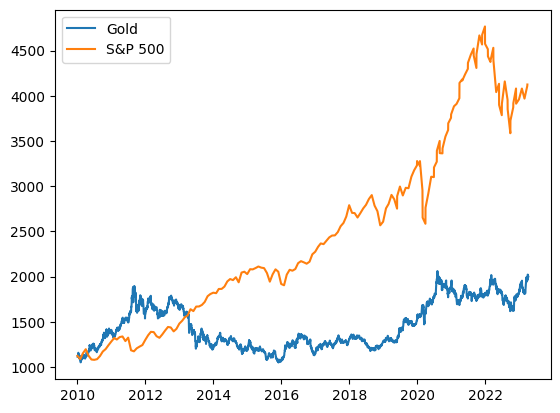

In [56]:
# plot the data of both the stocks
plt.plot(gold_data['USD (AM)'], label='Gold')
plt.plot(sp500_data['Value'], label='S&P 500')
plt.legend()

These are two different assets. Someone could have a portfolio with both gold and the SP500. 

Let's draw the investment opportunity set for these two assets.

> What is the investment opportunity set? It is the set of all possible portfolios that can be constructed from a given set of assets. In other words, it is the set of all possible combinations of the assets in the portfolio.

We will also color code this set by how high their Sharpe Ratio is

> What is the Sharpe Ratio? It is Sharpe Ratio = (Average Portfolio Return - Risk-Free Rate) / Portfolio Standard Deviation. A higher Sharpe ratio indicates that an investment has delivered a greater return for the amount of risk taken. Conversely, a lower Sharpe ratio indicates that an investment has delivered a lower return for the amount of risk taken. The Sharpe ratio is widely used by investors and portfolio managers as a tool to evaluate the performance of investments and to make investment decisions.


In [10]:

# show efficient frontier of returns against volatility
import numpy as np
import matplotlib.pyplot as plt

# Define the start and end dates
start_date = "2010-01-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

# Retrieve the historical price data for gold and SP500
gold_data = quandl.get("LBMA/GOLD", start_date=start_date, end_date=end_date)
sp500_data = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", start_date=start_date, end_date=end_date)

# Combine the two dataframes into a single portfolio dataframe
portfolio_data = pd.concat([gold_data['USD (PM)'], sp500_data['Value']], axis=1)
portfolio_data.columns = ['Gold', 'SP500']

# export the data to a csv file
portfolio_data.to_csv('portfolio_data.csv')

# Calculate the daily returns for the portfolio
daily_returns = portfolio_data.pct_change()

# Calculate the cumulative returns for the portfolio
cumulative_returns = (1 + daily_returns).cumprod() - 1

# Calculate the mean and standard deviation of the daily returns
mean_daily_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

# Set the number of runs of random portfolio weights
num_portfolios = 25000

# Set up array to hold results
# We have increased the size of the array to hold the weight values for each stock
results = np.zeros((4+len(portfolio_data.columns)-1, num_portfolios))

for i in range(num_portfolios):
    # Select random weights for portfolio holdings
    weights = np.array(np.random.random(2))
    # Rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    # Calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)


# Calculate Sharpe ratio
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    risk_free_rate = 0 # notice that we assume, naively, that the risk-free rate is 0
    # Sharpe ratio
    results[2,i] = (results[0,i] - risk_free_rate) / results[1,i]
    # Store weights
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

# Convert results array to Pandas DataFrame
results_frame = pd.DataFrame(results.T, columns=['ret','stdev','sharpe','Gold','SP500'])

# Locate position of portfolio with highest Sharpe ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]

# Locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

# Create scatter plot coloured by Sharpe ratio
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
# title of the plot
plt.title('Efficient Frontier of Returns against Volatility: Gold vs. SP500')

# Plot red star to highlight position of portfolio with highest Sharpe ratio
# plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=1000)''




ArgumentError: ArgumentError: Package numpy not found in current path:
- Run `import Pkg; Pkg.add("numpy")` to install the numpy package.


# Minimization Method (Newton-Rhapson)


##  Define the objective function: This function quantifies the risk-adjusted performance  of the portfolio. For instance, the Sharpe ratio, which is the ratio of the portfolio's  excess return (i.e., return above the risk-free rate) to its standard deviation, can be used  as the objective function

The objective function mentioned in the project is the Sharpe ratio. The Sharpe ratio is a widely used metric in finance for measuring the risk-adjusted performance of an investment portfolio. It is defined as the excess return of the portfolio over the risk-free rate divided by the portfolio's standard deviation. In mathematical notation, the Sharpe ratio can be expressed as:

\begin{equation}
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
\end{equation}

Where:

- $R_p$ is the expected portfolio return
- $R_f$ is the risk-free rate of return
- $σ_p$ is the portfolio's standard deviation (i.e., volatility)

The Sharpe ratio measures the excess return per unit of risk and is a useful tool for comparing the risk-adjusted performance of different portfolios. A higher Sharpe ratio indicates a better risk-adjusted performance, as the portfolio generates a higher return for each unit of risk taken. In the code provided, the Sharpe ratio is calculated for each randomly generated portfolio and stored in the results array. The portfolio with the highest Sharpe ratio is identified as the portfolio with the best risk-adjusted performance.

In [6]:
using Pkg
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("Optim")

using DataFrames, Plots, Optim


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [8]:
# Define the start and end dates
start_date = "2010-01-01"
end_date = Dates.format(Dates.now(), "yyyy-mm-dd")

UndefVarError: UndefVarError: Dates not defined

# Define the start and end dates
start_date = "2010-01-01"
end_date = Dates.format(Dates.now(), "yyyy-mm-dd")

# Retrieve the historical price data for gold and SP500
gold_data = Quandl.get("LBMA/GOLD", start_date=start_date, end_date=end_date)
sp500_data = Quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", start_date=start_date, end_date=end_date)

# Combine the two dataframes into a single portfolio dataframe
portfolio_data = hcat(gold_data[:, "USD (PM)"], sp500_data[:, "Value"])
rename!(portfolio_data, ["Gold", "SP500"])

# Calculate the daily returns for the portfolio
daily_returns = diff(log.(portfolio_data[2:end, :])) 

# Calculate the mean and standard deviation of the daily returns
mean_daily_returns = mean(daily_returns, dims=1)
cov_matrix = cov(daily_returns)

# Define objective function
function sharpe_ratio(weights::Array{Float64, 1})
    portfolio_return = dot(mean_daily_returns, weights) * 252
    portfolio_std_dev = sqrt(dot(weights, dot(cov_matrix, weights))) * sqrt(252)
    risk_free_rate = 0.0 # assuming the risk-free rate is 0
    return (portfolio_return - risk_free_rate) / portfolio_std_dev
end

# Define the optimization problem
function neg_sharpe_ratio(weights::Array{Float64, 1})
    return -sharpe_ratio(weights)
end

# Set initial weights and constraints
init_weights = [0.5, 0.5]
lower_bounds = [0.0, 0.0]
upper_bounds = [1.0, 1.0]
sum_constraint = Optim.LinearConstraints(A=[1.0 1.0], lb=[1.0], ub=[1.0])

# Perform optimization
opt_result = optimize(neg_sharpe_ratio, lower_bounds, upper_bounds, init_weights, Fminbox(); constraints=sum_constraint, autodiff=:forward)

# Get the optimal weights
optimal_weights = Optim.minimizer(opt_result)

# Print the optimal weights
println("Optimal weights: ", optimal_weights)
